In [ ]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix
from mlxtend.evaluate import bias_variance_decomp
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
def data_segmentation(df, y_label, window_size = 100, stride = 50):
    '''
    Segments the data into the same length and detach the whole dataset into X and y.
    
    df: data frame that contains all covariates and response variables
    y_label: the column name of the response variable that we want to predict
    window_size: the length of time included in a single data point
    stride: The interval between two closest segmented data point
    '''
    j = df.columns.get_loc(y_label)
    data = df.to_numpy()
    n = len(data)
    X = []
    y = []
    start = 0
    end = 0
    
    while start <= n - window_size:
        end = start + window_size - 1
        if data[start][j] == data[end][j] and data[start][0] + 0.01 > data[end][0] and data[start][j]!=0:
            X.append(data[start:(end+1),1:-7])
            y.append(data[start][j])
            start += stride
        else:
            while start + window_size - 1 < n:
                if data[start][j] != data[start+1][j]:
                    break
                start += 1
            start += 1
    return np.asarray(X), np.asarray(y)

In [3]:
def count_parameters(model):
    """Returns the total number of trainable parameters in the model."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
def train_model(model, data_loader, criterion, optimizer, num_epochs, scheduler=None, print_every_n_batches=100):
    """
    Trains the model and prints the parameter count and running loss periodically.
    Accepts an optional scheduler.
    """

    print(f"\nNumber of model parameters is: {count_parameters(model)}")

    model.train()
    model.to(device)

    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(data_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if (i + 1) % print_every_n_batches == 0:
                avg_loss = running_loss / print_every_n_batches
                print(f"Epoch [{epoch+1}/{num_epochs}] | Batch [{i+1}/{len(data_loader)}] | Running Loss: {avg_loss:.4f} | LR: {optimizer.param_groups[0]['lr']:.6f}")
                running_loss = 0.0
        if scheduler is not None:
            scheduler.step()

    print("\nFinished Training.")
    return model
def test_model(model, test_loader):
    """
    Tests the trained model and prints the parameter count and final accuracy.
    """
    print(f"\nNumber of model parameters is: {count_parameters(model)}")

    model.eval()
    model.to(device)
    correct = 0
    total = 0
    y_test = np.array([])
    y_pred = np.array([])
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            y_pred = np.append(y_pred, predicted.cpu().numpy())
            y_test = np.append(y_test, labels.cpu().numpy())
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        cm = confusion_matrix(y_test, y_pred)


        # Print the evaluation metrics
        print("Accuracy:", f"{accuracy:.4f}")
        print("Precision:", f"{precision:.4f}")
        print("Recall:", f"{recall:.4f}")
        print("F1 Score:", f"{f1:.4f}")
        print(f"\nTest accuracy of model: {accuracy*100:.2f}%")
        cm = confusion_matrix(y_test, y_pred)

        # plot the confusion matrix
        plt.figure(figsize=(8, 8))
        sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
        plt.xticks(np.arange(5)+0.5, ['Relaxing', 'Coffee time', 'Early morning', 'Cleanup', 'Sandwich time'], rotation=90)
        plt.yticks(np.arange(5)+0.5, ['Relaxing', 'Coffee time', 'Early morning', 'Cleanup', 'Sandwich time'], rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    return accuracy

In [6]:
def create_static_features(X_data):
    """
    Calculates 5 static features (mean, std, max, min, last) 
    from a 3D time-series array.
    """
    # 1. Calculate features across the time dimension (axis=1)
    mean_features = np.mean(X_data, axis=1)
    std_features = np.std(X_data, axis=1)
    max_features = np.max(X_data, axis=1)
    min_features = np.min(X_data, axis=1)
    
    # 2. Get the last time step's features
    # Shape is (samples, features)
    last_features = X_data[:, -1, :]
    
    # 3. Concatenate all new features horizontally (axis=1)
    # Each array has shape (samples, features), e.g., (5000, 5)
    # The final array will have shape (samples, features * 5)
    X_static = np.concatenate(
        (mean_features, std_features, max_features, min_features, last_features), 
        axis=1
    )
    
    return X_static

# --- Create the new feature sets ---
X_train_static = create_static_features(X_train)
X_test_static = create_static_features(X_test)

In [14]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        """
        Args:
            input_size (int): The number of features in the input data (e.g., 5 variables).
            hidden_size (int): The number of neurons in the LSTM's hidden state.
            num_layers (int): The number of stacked LSTM layers.
            output_size (int): The number of output values (e.g., 1 for a single prediction).
        """
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, bidirectional=True, batch_first=True)
        self.head = nn.Sequential(
            nn.Linear(hidden_size*2, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64,32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(32, output_size)
        )

    def forward(self, x):
        """
        The forward pass of the model.
        
        Args:
            x (torch.Tensor): The input tensor of shape (batch_size, seq_length, input_size).
        """
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        out, (hn, cn) = self.lstm(x)
        last_time_step_out = torch.cat((hn[-2, :, :], hn[-1, :, :]), dim=1)
        final_out = self.head(last_time_step_out)
        
        return final_out

In [5]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
X_train, y_train = data_segmentation(df_train, "HL_Activity")
X_test, y_test = data_segmentation(df_test, "HL_Activity")  
y_train -= 101
y_test -= 101

C:\Users\yizhou\AppData\Local\Temp\ipykernel_82464\3083132224.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train).float()
C:\Users\yizhou\AppData\Local\Temp\ipykernel_82464\3083132224.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train).long()
C:\Users\yizhou\AppData\Local\Temp\ipykernel_82464\3083132224.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test).float()
C:\Users\yizhou\AppData\Local\Temp\ipykernel_82464\3083132224.py:14: UserWarning: 


Model Architecture:
LSTMModel(
  (lstm): LSTM(242, 128, num_layers=2, batch_first=True, bidirectional=True)
  (head): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=32, out_features=5, bias=True)
  )
)

Number of model parameters is: 795077
Epoch [1/10] | Batch [100/515] | Running Loss: 1.6042 | LR: 0.000100
Epoch [1/10] | Batch [200/515] | Running Loss: 1.3546 | LR: 0.000100
Epoch [1/10] | Batch [300/515] | Running Loss: 1.2677 | LR: 0.000100
Epoch [1/10] | Batch [400/515] | Running Loss: 1.1773 | LR: 0.000100
Epoch [1/10] | Batch [500/515] | Running Loss: 1.1170 | LR: 0.000100
Epoch [2/10

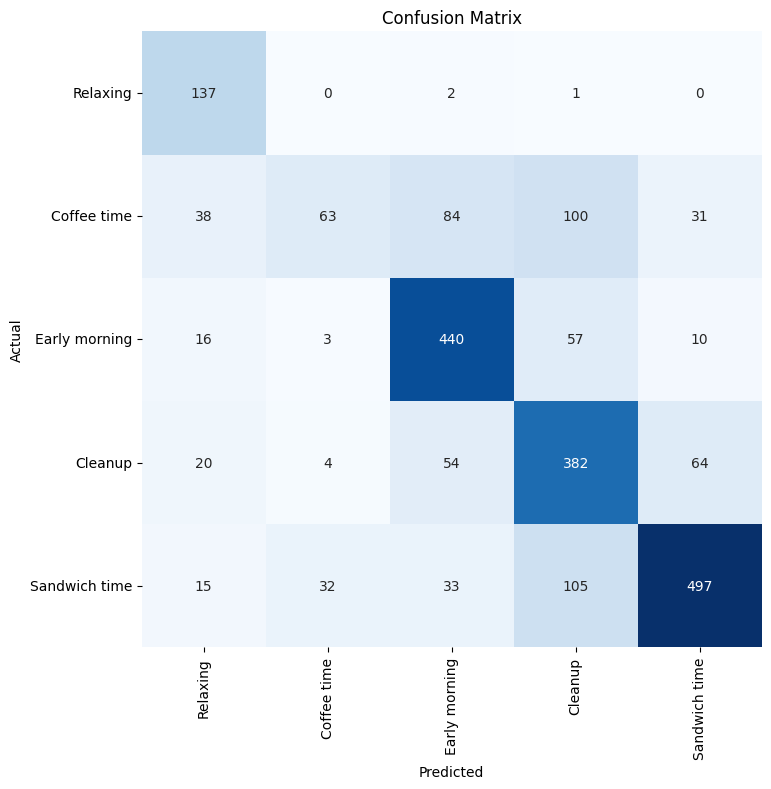

In [16]:
input_size = X_train.shape[2]
sequence_length = 100
hidden_size = 128
num_layers = 2
output_size = 5

# Training Hyperparameters
batch_size = 16
num_epochs = 100
learning_rate = 0.0001
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).long()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).long()
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
trainloader = torch.utils.data.DataLoader(train_dataset
    , batch_size=batch_size,
    shuffle=True, num_workers=4)

testloader = torch.utils.data.DataLoader(test_dataset
    , batch_size=batch_size,
    shuffle=False, num_workers=4)

model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)

# Using Mean Squared Error loss for a regression problem
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
print("\nModel Architecture:")
print(model)
train_model(model, trainloader, criterion, optimizer, num_epochs=10, scheduler=scheduler)
acc = test_model(model, testloader)




In [54]:
def train_model(model, data_loader, criterion, optimizer, num_epochs, scheduler=None, print_every_n_batches=100):
    """
    Trains the model and prints the parameter count and running loss periodically.
    Accepts an optional scheduler.
    """

    print(f"\nNumber of model parameters is: {count_parameters(model)}")

    model.train()
    model.to(device)

    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, static, labels) in enumerate(data_loader):
            inputs, static, labels = inputs.to(device), static.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs, static)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if (i + 1) % print_every_n_batches == 0:
                avg_loss = running_loss / print_every_n_batches
                print(f"Epoch [{epoch+1}/{num_epochs}] | Batch [{i+1}/{len(data_loader)}] | Running Loss: {avg_loss:.4f} | LR: {optimizer.param_groups[0]['lr']:.6f}")
                running_loss = 0.0
        if scheduler is not None:
            scheduler.step()

    print("\nFinished Training.")
    return model
def test_model(model, test_loader):
    """
    Tests the trained model and prints the parameter count and final accuracy.
    """
    print(f"\nNumber of model parameters is: {count_parameters(model)}")

    model.eval()
    model.to(device)
    correct = 0
    total = 0
    y_pred = np.array([])
    y_test = np.array([])
    with torch.no_grad():
        for i, (inputs, static, labels) in enumerate(test_loader):
            inputs, static, labels = inputs.to(device), static.to(device), labels.to(device)
            outputs = model(inputs, static)
            _, predicted = torch.max(outputs.data, 1)
            y_pred = np.append(y_pred, predicted.cpu().numpy())
            y_test = np.append(y_test, labels.cpu().numpy())
        print(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        cm = confusion_matrix(y_test, y_pred)


        # Print the evaluation metrics
        print("Accuracy:", f"{accuracy:.4f}")
        print("Precision:", f"{precision:.4f}")
        print("Recall:", f"{recall:.4f}")
        print("F1 Score:", f"{f1:.4f}")
        print(f"\nTest accuracy of model: {accuracy*100:.2f}%")
        cm = confusion_matrix(y_test, y_pred)

        # plot the confusion matrix
        plt.figure(figsize=(8, 8))
        sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
        plt.xticks(np.arange(5)+0.5, ['Relaxing', 'Coffee time', 'Early morning', 'Cleanup', 'Sandwich time'], rotation=90)
        plt.yticks(np.arange(5)+0.5, ['Relaxing', 'Coffee time', 'Early morning', 'Cleanup', 'Sandwich time'], rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    return accuracy

In [27]:
class CombinedModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, 
                 num_static_features, output_size):
        
        super(CombinedModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM part
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # Head part
        combined_input_size = hidden_size + num_static_features
        self.seq = nn.Sequential(
            nn.Linear(combined_input_size, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(32, output_size)
        )

    # The forward pass now takes TWO inputs
    def forward(self, x_sequence, x_static):
        # Process sequence
        h0 = torch.zeros(self.num_layers, x_sequence.size(0), self.hidden_size).to(x_sequence.device)
        c0 = torch.zeros(self.num_layers, x_sequence.size(0), self.hidden_size).to(x_sequence.device)
        out, _ = self.lstm(x_sequence, (h0, c0))
        lstm_out = out[:, -1, :]
        
        # Concatenate LSTM output with static features
        combined = torch.cat((lstm_out, x_static), dim=1)
        
        # Pass combined vector to the head
        return self.seq(combined)

C:\Users\yizhou\AppData\Local\Temp\ipykernel_76528\2814253581.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train).float()
C:\Users\yizhou\AppData\Local\Temp\ipykernel_76528\2814253581.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_static = torch.tensor(X_train_static).float()
C:\Users\yizhou\AppData\Local\Temp\ipykernel_76528\2814253581.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train).long()
C:\Users\yizhou\AppData\Local\Temp\ipykernel_76528\2814253581.py:1


Model Architecture:
CombinedModel(
  (lstm): LSTM(242, 128, num_layers=2, batch_first=True)
  (seq): Sequential(
    (0): Linear(in_features=1338, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=32, out_features=5, bias=True)
  )
)

Number of model parameters is: 410693
Epoch [1/10] | Batch [100/515] | Running Loss: 1.6060 | LR: 0.000100
Epoch [1/10] | Batch [200/515] | Running Loss: 1.4090 | LR: 0.000100
Epoch [1/10] | Batch [300/515] | Running Loss: 1.2523 | LR: 0.000100
Epoch [1/10] | Batch [400/515] | Running Loss: 1.1929 | LR: 0.000100
Epoch [1/10] | Batch [500/515] | Running Loss: 1.1028 | LR: 0.000100
Epoch [2/10] | Batch [100/5

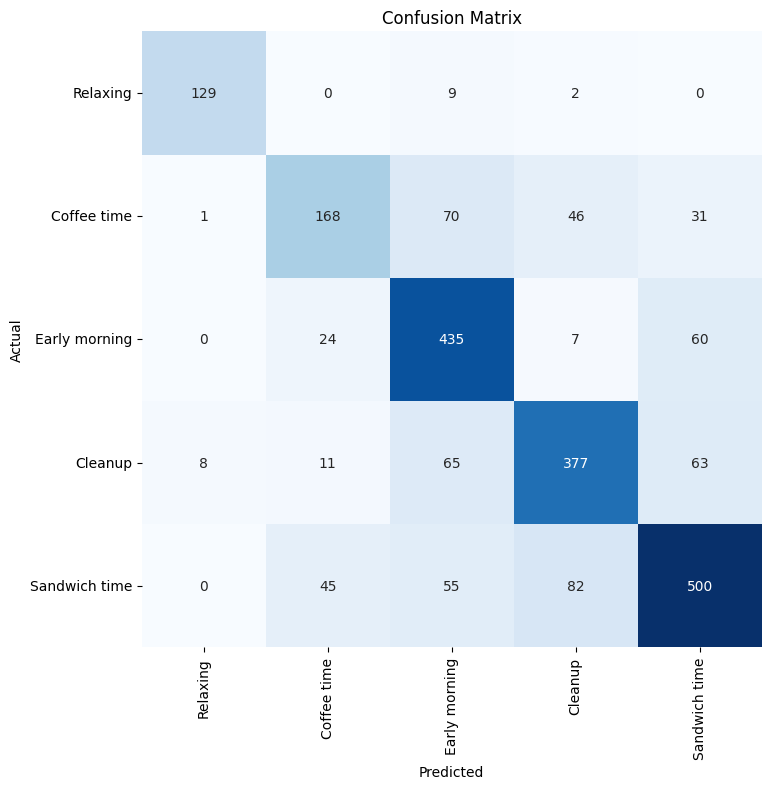

In [ ]:
input_size = X_train.shape[2]
num_static_features = X_train_static.shape[1]
sequence_length = 100
hidden_size = 128
num_layers = 2
output_size = 5

# Training Hyperparameters
batch_size = 16
num_epochs = 100
learning_rate = 0.0001
X_train = torch.tensor(X_train).float()
X_train_static = torch.tensor(X_train_static).float()
y_train = torch.tensor(y_train).long()
X_test = torch.tensor(X_test).float()
X_test_static = torch.tensor(X_test_static).float()
y_test = torch.tensor(y_test).long()
train_dataset = TensorDataset(X_train,X_train_static, y_train)
test_dataset = TensorDataset(X_test,X_test_static, y_test)
train_size = int(0.8*len(train_dataset))
val_size = int(len(train_dataset)) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
trainloader = torch.utils.data.DataLoader(train_dataset
    , batch_size=batch_size,
    shuffle=True, num_workers=4)
valloader = torch.utils.data.DataLoader(val_dataset
    , batch_size=batch_size,
    shuffle=False, num_workers=4
)
testloader = torch.utils.data.DataLoader(test_dataset
    , batch_size=batch_size,
    shuffle=False, num_workers=4)

model = CombinedModel(input_size=input_size, hidden_size=hidden_size, 
                      num_layers=num_layers,
                      num_static_features=num_static_features,
                      output_size=output_size).to(device)

# Using Mean Squared Error loss for a regression problem
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
print("\nModel Architecture:")
print(model)
train_model(model, trainloader, criterion, optimizer, num_epochs=10, scheduler=scheduler)
acc = test_model(model, valloader)


Number of model parameters is: 410693
[0. 0. 0. ... 0. 0. 0.] [0. 0. 0. ... 0. 0. 0.]
Accuracy: 0.7041
Precision: 0.7557
Recall: 0.7041
F1 Score: 0.6929

Test accuracy of model: 0.70%


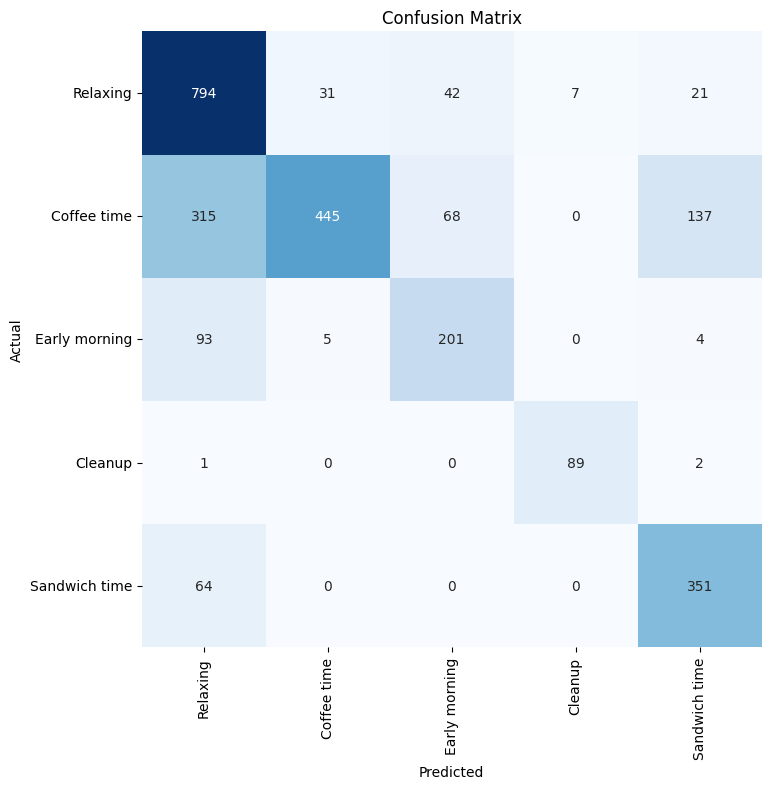

In [44]:
acc = test_model(model, testloader)